# testing the algorithm for the calculation of the meridional SALT/FW transport terms

In [1]:
import os
import sys
import xgcm
import numpy as np
import xarray as xr
import cmocean
import cartopy
import warnings
import pop_tools
import matplotlib
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
%matplotlib inline
matplotlib.rc_file('rc_file_paper')
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2
%aimport - numpy - scipy - matplotlib.pyplot

In [3]:
from MOC import approx_lats
from maps import add_cyclic_POP
from tqdm import notebook
from paths import file_ex_ocn_ctrl, file_ex_ocn_rcp, file_ex_ocn_lpd, path_prace, path_results, file_RMASK_ocn, file_RMASK_ocn_low
from filters import lowpass
from constants import rho_sw  # [kg/m^3]
from timeseries import IterateOutputCESM
from cartopy.util import add_cyclic_point
from FW_transport import calc_transports_pbc
from xr_regression import xr_lintrend, xr_linear_trend, xr_linear_trends_2D, xr_2D_trends
from xr_DataArrays import xr_DZ, xr_DZ_xgcm

In [4]:
dsh = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False)
dsl = xr.open_dataset(file_ex_ocn_lpd, decode_times=False)

In [5]:
DZU_high = xr_DZ('ocn', grid='U')
DZU_low = xr_DZ('ocn_low', grid='U')

In [6]:
RMASK_ocn = xr.open_dataarray(file_RMASK_ocn)
RMASK_low = xr.open_dataarray(file_RMASK_ocn_low)
Atl_MASK_ocn = xr.DataArray(np.in1d(RMASK_ocn, [6,8,9]).reshape(RMASK_ocn.shape),
                            dims=RMASK_ocn.dims, coords=RMASK_ocn.coords)
Atl_MASK_low = xr.DataArray(np.in1d(RMASK_low, [6,8,9]).reshape(RMASK_low.shape),
                            dims=RMASK_low.dims, coords=RMASK_low.coords)

In [7]:
cesm_dict = dict(concat_dim='time', decode_times=False, combine='nested')
obs_dict = dict(combine='nested', concat_dim='Time', chunks={'Latitude':96, 'Longitude':270, 'Time':73})
ctrl = xr.open_mfdataset(file_ex_ocn_ctrl[:-5]+'*.nc', **cesm_dict).mean('time')
lpd = xr.open_mfdataset(file_ex_ocn_lpd[:-5]+'*.nc', **cesm_dict).mean('time')
obs = xr.open_mfdataset(f'{path_prace}/SSH/ssh_grids_v1812_*.nc', **obs_dict)

ctrl_std = np.sqrt(np.abs(ctrl.SSH2-ctrl.SSH**2))
ctrl_std = ctrl_std.where(RMASK_ocn!=-1)
lpd_std = np.sqrt(lpd.SSH2-lpd.SSH**2)
obs_std = np.sqrt((obs.SLA**2).mean('Time')-obs.SLA.mean('Time')**2)

In [8]:
# calculated in 
psi_ctrl = xr.open_dataarray(f'{path_prace}/BSF/BSF_ctrl.nc', decode_times=False).mean('time')
psi_lpd  = xr.open_dataarray(f'{path_prace}/BSF/BSF_lpd.nc' , decode_times=False).mean('time')

In [9]:
colors1 = cmocean.cm.delta(np.linspace(0., 1, 24))
colors2 = cmocean.cm.curl(np.linspace(0, 1, 24))
colors = np.vstack((colors1, colors2))
mycmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

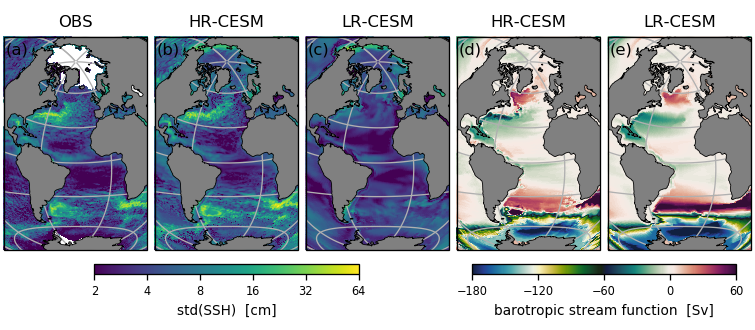

In [10]:
f = plt.figure(figsize=(6.4,2.8))
y, dy = 0.2, 0.73
for i in range(5):
    axt = f.add_axes([i*.2+0.005,y,.19,dy], projection=ccrs.LambertAzimuthalEqualArea(central_longitude=-30, central_latitude=20))
    axt.set_extent((-6e6, 3.5e6, -8.5e6, 1e7), crs=ccrs.LambertAzimuthalEqualArea())
    axt.set_title(['OBS', 'HR-CESM', 'LR-CESM', 'HR-CESM', 'LR-CESM'][i])
    latname, lonname = 'TLAT', 'TLONG'
    if i<3:
        if i==0:
            xa = obs_std.T*100
            latname, lonname = 'Latitude', 'Longitude'
        if i==1:
            xa = ctrl_std
        if i==2:
            xa = add_cyclic_POP(lpd_std)
        minv, maxv = -6, 6
        cmap = 'viridis'
        norm = matplotlib.colors.LogNorm(vmin=2, vmax=64)
        im = axt.pcolormesh(xa[lonname], xa[latname], xa.values, transform=ccrs.PlateCarree(), norm=norm)
        if i==1:
            cax = f.add_axes([0.125,.17,.35,.03])
            ticks = [2**x for x in range(1,7)]
            cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=r'std(SSH)  [cm]')
            cbar.ax.minorticks_off()
            cbar.ax.get_xaxis().set_ticks(ticks)
            cbar.ax.get_xaxis().set_ticklabels(ticks)
        
    elif i==3 or i==4:        
        if i==3:
            xa = (psi_ctrl-psi_ctrl.isel({'nlat':1300, 'nlon':1300})).squeeze().where(RMASK_ocn>0)
        if i==4:
            xa = add_cyclic_POP((psi_lpd-psi_lpd.isel({'nlat':200, 'nlon':50})).squeeze().where(RMASK_low>0))
        im = axt.pcolormesh(xa[lonname], xa[latname], xa.values, transform=ccrs.PlateCarree(),
                            cmap=mycmap, vmin=-180, vmax=60)
        if i==3: 
            cax = f.add_axes([0.625,.17,.35,.03])
            cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label='barotropic stream function  [Sv]', ticks=np.arange(-180,61,60))
    
    axt.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black', facecolor='grey', linewidth=.5)
    gl = axt.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
    gl.ylocator = matplotlib.ticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    axt.text(0.01, .92, '('+['a', 'b', 'c', 'd', 'e'][i]+')', transform=axt.transAxes)
# plt.savefig(f'{path_results}/FW-paper/Fig4', dpi=600)

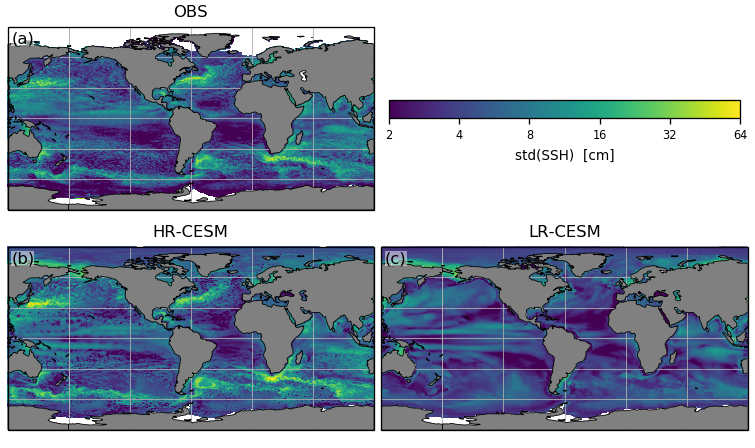

In [11]:
from obs_cesm_maps import bias_maps
from maps import add_cyclic_POP
kw = dict(lat='Latitude', lon='Longitude', label='std(SSH)  [cm]', cmap='viridis', vmin=2, vmax=64, log=True, ticks = [2**x for x in range(1,7)])
bias_maps(do=obs_std.T*100, dh=ctrl_std, dl=add_cyclic_POP(lpd_std), kw1=kw, kw2=None, fn=f'{path_results}/FW-paper/SupplFig4')